In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-aspects/all_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_sentences.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled_sentences.csv
/kaggle/input/all-aspects/reviews.csv
/kaggle/input/all-aspects/cleaned.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects.csv
/kaggle/input/all-aspects/all_aspects.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned_sentences.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import torch
import matplotlib.pyplot as plt
from torch import nn
from transformers import ConvBertTokenizerFast, ConvBertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Dataset
from transformers import AdamW
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv("../input/all-aspects/all_tagged_aspects_just_aspect_cleaned_sentences.csv")
df.head()

,sentence,word_labels
0,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,"O,O,B-A,O,O,O,O,B-A,O,O,O"
1,Her güncellemede daha da kötüleşen Turkcell in...,"O,O,O,O,O,B-A,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,BiP’ten aranmıyor yardım,"B-A,O,O"
3,Bu yorumum kesinlikle uygulamanın daha çok gel...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-A,O,O,O,..."
4,kurumlarda WhatsApp engelleniyor Alternatif ol...,"O,B-A,O,O,O,B-A,O,O,B-A,O,O,O,O,O,O,O,B-A,O,O,..."


In [5]:
df.shape

(113203, 2)

In [6]:
labels_to_ids = {'O': 0, 'B-A': 1, 'I-A': 2}
ids_to_labels = {0: 'O', 1: 'B-A', 2: 'I-A'}

In [7]:
MAX_LEN = 128
EPOCHS = 1
LEARNING_RATE = 2e-05
MAX_GRAD_NORM = 10

In [8]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        encoding = self.tokenizer(sentence, return_offsets_mapping=True, padding='max_length', truncation=True, max_length=self.max_len)
        
        labels = [labels_to_ids[label] for label in word_labels] 
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                encoded_labels[idx] = labels[i]
                i += 1
      
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels) 
        return item

    def __len__(self):
        return self.len

In [10]:
tokenizer = ConvBertTokenizerFast.from_pretrained('dbmdz/convbert-base-turkish-cased')

In [11]:
model = ConvBertForTokenClassification.from_pretrained('dbmdz/convbert-base-turkish-cased', num_labels=len(labels_to_ids)).to(device)

model.safetensors:   0%|          | 0.00/427M [00:00<?, ?B/s]

Some weights of ConvBertForTokenClassification were not initialized from the model checkpoint at dbmdz/convbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(train_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [13]:
train_size = 0.9
df_train, df_validation, df_test = train_validate_test_split(df, train_size)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Full dataset: {df.shape[0]}")
print(f"Train dataset: {df_train.shape[0]}")
print(f"Valid dataset: {df_validation.shape[0]}")
print(f"Test dataset: {df_test.shape[0]}")

training_set = dataset(df_train, tokenizer, MAX_LEN)
validation_set = dataset(df_validation, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

Full dataset: 113203
Train dataset: 101882
Valid dataset: 5660
Test dataset: 5661


In [14]:
train_params = {"batch_size": 32, "shuffle": True, "num_workers": 0}
valid_params = {"batch_size": 32, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": 32, "shuffle": True, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [20]:
def train_model(model, training_loader, optimizer, max_grad_norm, epochs):
    for epoch in range(epochs):
        print(f"Training epoch: {epoch + 1}")
        model.train()
        tr_loss, tr_accuracy = 0, 0
        nb_tr_steps = 0
        tr_preds, tr_labels = [], []

        for idx, batch in enumerate(training_loader):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = output.loss
            tr_logits = output.logits
            tr_loss += loss.item()

            nb_tr_steps += 1
            if idx % 1000 == 0:
                print(f"Training loss per 1000 training steps: {tr_loss / nb_tr_steps}")
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()

            flattened_targets = labels.view(-1)
            active_logits = tr_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)

            active_accuracy = labels.view(-1) != -100
            active_targets = torch.masked_select(flattened_targets, active_accuracy)
            active_predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(active_targets.cpu().numpy())
            tr_preds.extend(active_predictions.cpu().numpy())

        tr_loss /= nb_tr_steps
        tr_accuracy = np.sum(np.array(tr_preds) == np.array(tr_labels)) / len(tr_labels)

        print(f"Training loss epoch: {tr_loss}")
        print(f"Training accuracy epoch: {tr_accuracy}")

In [21]:
%%time

train_model(model, training_loader, optimizer, MAX_GRAD_NORM, EPOCHS)

Training epoch: 1
Training loss per 1000 training steps: 0.9994337558746338
Training loss per 1000 training steps: 0.04578769267383185
Training loss per 1000 training steps: 0.029692627982892
Training loss per 1000 training steps: 0.023736176288811448
Training loss epoch: 0.02335716666135368
Training accuracy epoch: 0.9939734202312479
CPU times: user 36min 17s, sys: 43.4 s, total: 37min
Wall time: 37min


In [22]:
def validate_model(model, testing_loader):
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids=ids, attention_mask=mask, labels=labels)
            eval_loss += output.loss.item()
            eval_logits = output.logits

            nb_eval_steps += 1
            if idx % 1000 == 0:
                print(f"Validation loss per 1000 evaluation steps: {eval_loss / nb_eval_steps}")

            flattened_targets = labels.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)

            active_accuracy = labels.view(-1) != -100
            active_targets = torch.masked_select(flattened_targets, active_accuracy)
            active_predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(active_targets.cpu().numpy())
            eval_preds.extend(active_predictions.cpu().numpy())

    eval_loss /= nb_eval_steps
    eval_accuracy = np.sum(np.array(eval_preds) == np.array(eval_labels)) / len(eval_labels)

    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    return eval_labels, eval_preds

In [23]:
def evaluate_model(labels, predictions):
    labels = [ids_to_labels[id.item()] for id in labels]
    predictions = [ids_to_labels[id.item()] for id in predictions]
    
    recall_val = recall_score(y_true=labels, y_pred=predictions, average='micro')
    print(f'Recall Score: {recall_val}')

    precision_val = precision_score(y_true=labels, y_pred=predictions, average='micro')
    print(f'Precision Score: {precision_val}')

    f1_val = f1_score(y_true=labels, y_pred=predictions, average='micro')
    print(f'F1 Score: {f1_val}')

    acc_val = accuracy_score(y_true=labels, y_pred=predictions)
    print(f"Accuracy Score: {acc_val}")

    cm = confusion_matrix(y_true=labels, y_pred=predictions)
    print("Confusion Matrix:")
    print(cm)

    print("Classification Report:")
    print(classification_report(labels, predictions))

    plt.figure()
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=np.unique(labels))
    plt.title("BERT - Aspect Extraction")
    plt.show()

##### Validation #####
Validation loss per 1000 evaluation steps: 0.006736523937433958
Validation Loss: 0.011888190190699793
Validation Accuracy: 0.9975265017667845
Recall Score: 0.9975265017667845
Precision Score: 0.9975265017667845
F1 Score: 0.9975265017667845
Accuracy Score: 0.9975265017667845
Confusion Matrix:
[[1577    0    4]
 [   4   43    2]
 [   3    1 4026]]
Classification Report:
              precision    recall  f1-score   support

         B-A       1.00      1.00      1.00      1581
         I-A       0.98      0.88      0.92        49
           O       1.00      1.00      1.00      4030

    accuracy                           1.00      5660
   macro avg       0.99      0.96      0.97      5660
weighted avg       1.00      1.00      1.00      5660



<Figure size 640x480 with 0 Axes>

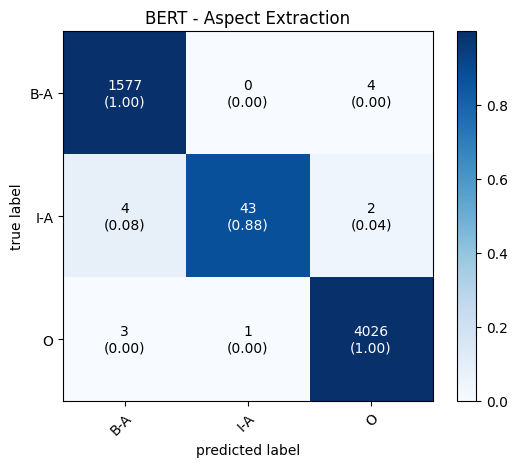

CPU times: user 41.4 s, sys: 180 ms, total: 41.6 s
Wall time: 41.4 s


In [24]:
%%time

print("##### Validation #####")
labels, predictions = validate_model(model, validation_loader)
evaluate_model(labels, predictions)

##### Testing #####
Validation loss per 1000 evaluation steps: 0.023223724216222763
Validation Loss: 0.009206722973415755
Validation Accuracy: 0.9987634693517047
Recall Score: 0.9987634693517047
Precision Score: 0.9987634693517047
F1 Score: 0.9987634693517047
Accuracy Score: 0.9987634693517047
Confusion Matrix:
[[1597    1    2]
 [   2   62    0]
 [   1    1 3995]]
Classification Report:
              precision    recall  f1-score   support

         B-A       1.00      1.00      1.00      1600
         I-A       0.97      0.97      0.97        64
           O       1.00      1.00      1.00      3997

    accuracy                           1.00      5661
   macro avg       0.99      0.99      0.99      5661
weighted avg       1.00      1.00      1.00      5661



<Figure size 640x480 with 0 Axes>

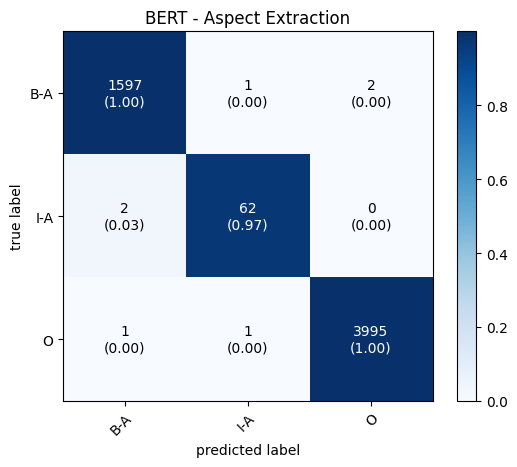

CPU times: user 42.4 s, sys: 157 ms, total: 42.5 s
Wall time: 42.3 s


In [25]:
%%time

print("##### Testing #####")
labels, predictions = validate_model(model, testing_loader)
evaluate_model(labels, predictions)

In [26]:
def align_word_predictions(tokens, token_predictions):
    aligned_tokens = []
    aligned_predictions = []

    for token, prediction in zip(tokens, token_predictions):
        if not token.startswith("##"):
            aligned_tokens.append(token)
            aligned_predictions.append(prediction)
        else:
            aligned_tokens[-1] = aligned_tokens[-1] + token[2:]

    return aligned_tokens, aligned_predictions

In [59]:
#sentence = "Fiber 100mb SuperOnline kullanıcısıyım yaklaşık 2 haftadır Twitch Kick_Turkey gibi canlı yayın platformlarında 360p yayın izlerken donmalar yaşıyoruz. Başka hiç bir operatörler bu sorunu yaşamazken ben parasını verip alamadığım hizmeti neden ödeyeyim ? Turkcell "
sentence = 	"baska bir operatörler İnternetiniz yokken bile msj atilio"

In [60]:
inputs = tokenizer(sentence,
                    # is_pretokenized=True, 
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

In [61]:
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)

with torch.no_grad():
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) 
flattened_predictions = torch.argmax(active_logits, axis=1) 

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions))

In [62]:
aligned_tokens, aligned_predictions = align_word_predictions(tokens, token_predictions)

print("Sample input sentence:")
print("{:30}||{:10}".format("Word", "Pred"))
print(30 * "=")
for w, pred in zip(aligned_tokens, aligned_predictions):
    if w not in ["[PAD]", "[CLS]", "[SEP]"]:
        print("{:30}||{:10}".format(w, pred))

Sample input sentence:
Word                          ||Pred      
baska                         ||O         
bir                           ||I-A       
operatörler                   ||B-A       
İnternetiniz                  ||O         
yokken                        ||O         
bile                          ||O         
msj                           ||O         
atilio                        ||O         
